In [1]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
np.seterr(divide="ignore")
import logging
import pickle
import glob

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from scipy import interp

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

In [80]:
def evaluate_models(pattern):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):
#         print("Loading %s" % filename),
            
        data = pickle.load(open(filename, "rb"))
        y = data[:, 0]
        y_pred = data[:, 1]
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred))
        fpr, tpr, _ = roc_curve(y, y_pred)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
#         print("ROC AUC = %.4f" % rocs[-1])
         
#     print("Mean ROC AUC = %.4f" % np.mean(rocs))
        
    return rocs, fprs, tprs

def plot_rocs(rocs, fprs, tprs, label="", color="r", show_all=False):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        if show_all:
            plt.plot(base_tpr, inv_fpr, alpha=0.1, color=color)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)


    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s" % label)
    
def plot_show(filename=None):
    plt.xlabel("Signal efficiency")
    plt.ylabel("1 / Background efficiency")
    plt.xlim([0.1, 1.0])
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()
    
def report_score(rocs, fprs, tprs, label):       
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    print("%32s\tROC AUC=%.4f+-%.2f\t1/FPR@TPR=0.5=%.2f+-%.2f" %  (label, 
                                                                   np.mean(rocs), 
                                                                   np.std(rocs),
                                                                   np.mean(inv_fprs[:, 225]),
                                                                   np.std(inv_fprs[:, 225])))

                     1 $k_t$ jet	ROC AUC=0.9602+-0.00	1/FPR@TPR=0.5=196.57+-9.91
                    2 $k_t$ jets	ROC AUC=0.9866+-0.00	1/FPR@TPR=0.5=2784.13+-497.67
                    5 $k_t$ jets	ROC AUC=0.9865+-0.00	1/FPR@TPR=0.5=1939.41+-421.76


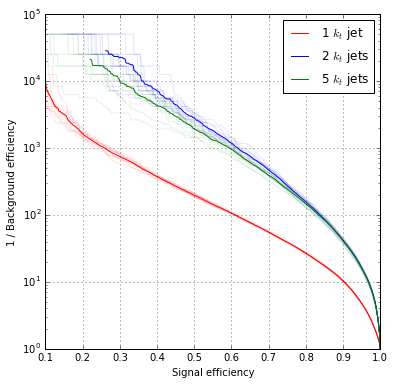

In [81]:
for pattern, n_jets, label, color in [
        ("antikt-kt", 1, "1 $k_t$ jet", "r"),
        ("antikt-kt", 2, "2 $k_t$ jets", "b"),
        ("antikt-kt", 5, "5 $k_t$ jets", "g")
    ]:
    
    r, f, t = evaluate_models("../models/event-study/predictions/predictions-e-full-%s-%d-*.pickle" % (pattern, n_jets))
    
    plot_rocs(r, f, t, label=label, color=color, show_all=True)
    report_score(r, f, t, label=label)
    
plot_show()

                1 desc-$p_T$ jet	ROC AUC=0.9594+-0.00	1/FPR@TPR=0.5=181.26+-14.87
               2 desc-$p_T$ jets	ROC AUC=0.9873+-0.00	1/FPR@TPR=0.5=2650.47+-448.79
               5 desc-$p_T$ jets	ROC AUC=0.9870+-0.00	1/FPR@TPR=0.5=2264.98+-249.68


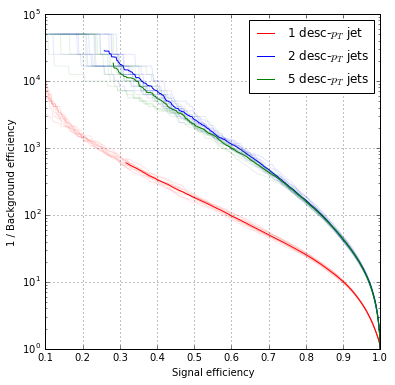

In [82]:
for pattern, n_jets, label, color in [
        ("antikt-seqpt-reversed", 1, "1 desc-$p_T$ jet", "r"),
        ("antikt-seqpt-reversed", 2, "2 desc-$p_T$ jets", "b"),
        ("antikt-seqpt-reversed", 5, "5 desc-$p_T$ jets", "g")
    ]:
    
    r, f, t = evaluate_models("../models/event-study/predictions/predictions-e-full-%s-%d-*.pickle" % (pattern, n_jets))
    
    plot_rocs(r, f, t, label=label, color=color, show_all=True)
    report_score(r, f, t, label=label)
    
plot_show()